In [1]:
# importing packages and modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
from io_utils import *
import dynamic_glmhmm
from scipy.stats import multivariate_normal, norm

sns.set_context("talk")

ibl_data_path = '../data_IBL'
colorsFeatures = [['#FAA61A','indigo','#99CC66','#59C3C3','#9593D9'],['#FAA61A',"#2369BD","#A9373B",'#99CC66','#59C3C3','#9593D9']]
colorsStates = ['tab:orange','tab:blue','tab:green','tab:purple', 'tab:brown']
colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']
myFeatures = [['bias','contrast right','contrast left', 'previous choice', 'previous reward'],['bias','signed stimulus', 'previous choice', 'previous reward']]
ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')

In [2]:
labChosen =  ['angelakilab','churchlandlab','wittenlab']
subjectsAll = []
for lab in labChosen:
    subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
    subjectsAll = subjectsAll + subjects

if ('NYU-01' in subjectsAll):
    subjectsAll.remove('NYU-01')
if ('NYU-06' in subjectsAll):
    subjectsAll.remove('NYU-06')
if ('CSHL_007' in subjectsAll):
    subjectsAll.remove('CSHL_007')
if ('CSHL049' in subjectsAll):
    subjectsAll.remove('CSHL049')

In [2]:
import json

# Open and read the JSON file
with open('../ihmm_trialwise_nlls.json', 'r') as file:
    data_Sebastian = json.load(file)

# Print the data
print(data_Sebastian)

{'NYU-02_2': 0.5742603524294715, 'CSHL_014_1': 0.6090935811427911, 'CSHL_004_3': 0.5359541293121273, 'ibl_witten_12_1': 0.6150570414767357, 'NYU-07_0': 0.5880024349174222, 'CSHL_008_4': 0.6233195533911372, 'CSHL_008_0': 0.6539761631664478, 'ibl_witten_12_3': 0.6018923274369526, 'ibl_witten_16_4': 0.6095078329780124, 'ibl_witten_12_2': 0.6215732549334083, 'CSHL_008_1': 0.6602427787046924, 'CSHL_003_4': 0.5726938345999559, 'CSHL_003_0': 0.576558152338823, 'NYU-07_2': 0.6014744104539701, 'NYU-07_1': 0.5899560356698261, 'CSHL_004_2': 0.5344134303393062, 'NYU-02_0': 0.5750953371378494, 'NYU-02_1': 0.5832940259415017, 'ibl_witten_16_2': 0.6211973291416101, 'CSHL_004_0': 0.5366964513013467, 'CSHL_014_2': 0.5842966401902765, 'NYU-02_4': 0.5799025705513096, 'CSHL_014_0': 0.5888776190063941, 'CSHL_010_1': 0.583524411847881, 'ibl_witten_16_1': 0.6275136688047368, 'CSHL_008_2': 0.6509717301124917, 'CSHL_010_2': 0.5892797428964204, 'CSHL_010_3': 0.5891444449457651, 'NYU-07_4': 0.5759463920203378, '

In [3]:
animals_Sebastian = ['NYU-02','CSHL_014','CSHL_004','ibl_witten_12','NYU-07','CSHL_008','ibl_witten_16','CSHL_003','CSHL_010']

In [23]:
K = 3
splitFolds = 5
pTanh = 5
signedStimulus = True
bestSigmaInd=7
Sebastians = []
Lencas = []
for subject in animals_Sebastian:
    print(subject)
    for fold in range(splitFolds):
        data = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_signedStimulus={signedStimulus}.npz')
        x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)
        _, _, _, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, None)
        print(firstBlockSession)
        # print(data['testLlSessions'][bestSigmaInd, :sessStop].mean())
        Lencas.append(data['testLlSessions'][bestSigmaInd, :firstBlockSession].mean())
        # print(data_Sebastian[f'{subject}_{fold}'])
        Sebastians.append(np.log(data_Sebastian[f'{subject}_{fold}']))
        

NYU-02
9
9
9
9
9
CSHL_014
15
15
15
15
15
CSHL_004
44
44
44
44
44
ibl_witten_12
9
9
9
9
9
NYU-07
13
13
13
13
13
CSHL_008
17
17
17
17
17
ibl_witten_16
15
15
15
15
15
CSHL_003
22
22
22
22
22
CSHL_010
16
16
16
16
16


In [25]:
print(np.mean(Sebastians))
print(np.mean(Lencas))

-0.5245326195055265
-0.5008435064360864


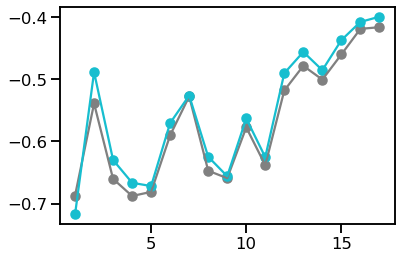

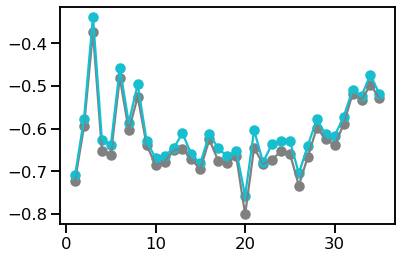

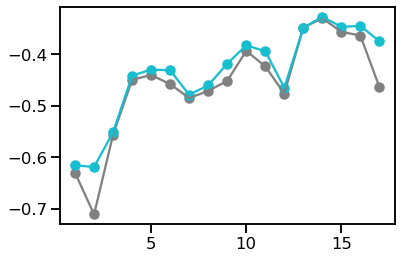

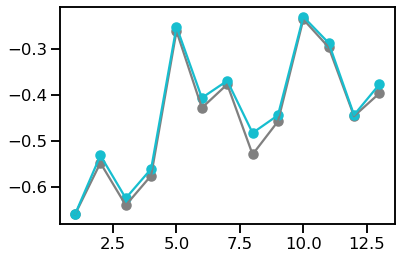

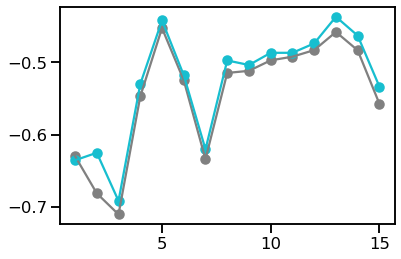

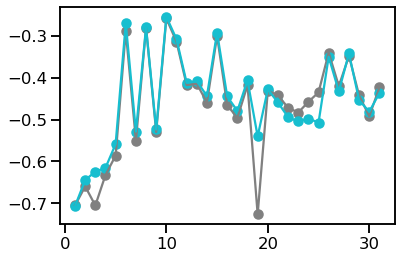

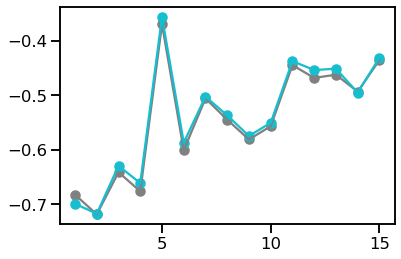

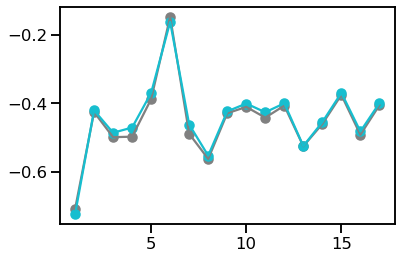

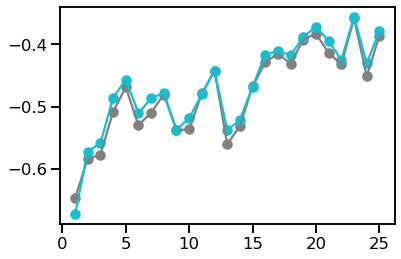

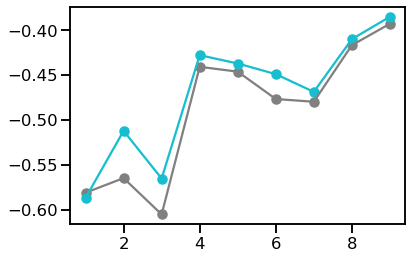

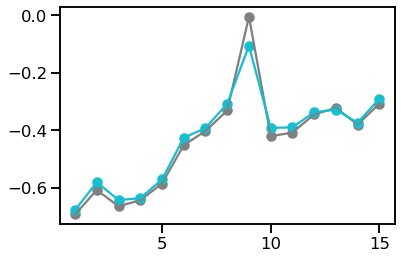

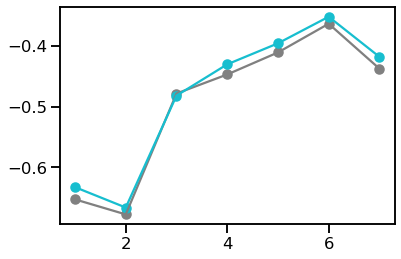

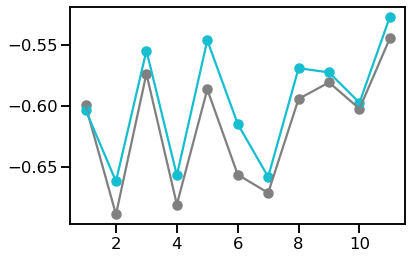

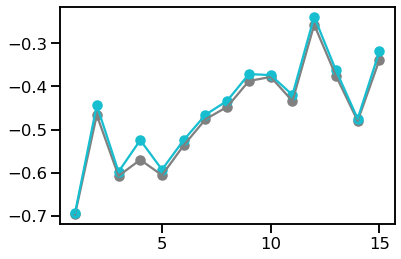

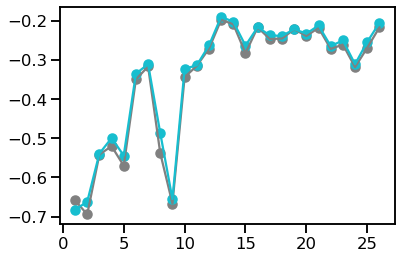

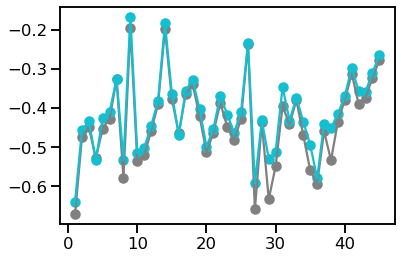

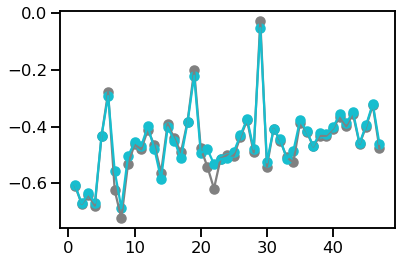

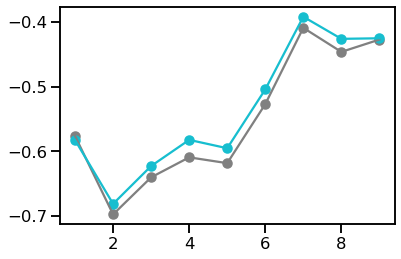

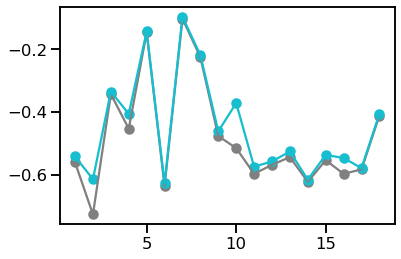

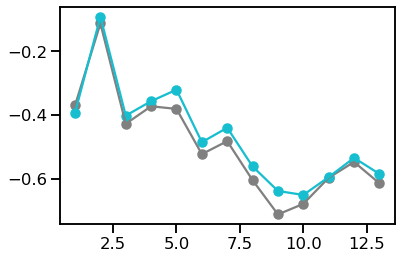

In [21]:
animals_Sebastian = ['CSHL_003','CSHL_004','CSHL_005','CSHL_008','CSHL_010','CSHL_012','CSHL_014','CSHL_015','ibl_witten_06','ibl_witten_12','ibl_witten_13','ibl_witten_14','ibl_witten_15','ibl_witten_16','IBL-T1','IBL-T2','IBL-T3','NYU-02','NYU-04','NYU-07']
pTanh = 5
L2penaltyW = 0
bestSigmaInd = 7
K = 3
splitFolds = 5
signedStimulus = True
for subject in animals_Sebastian:
    ll_Sebastian = np.load(f'../data_IBL/sab_results_/sab_results_{subject}.npy').mean(axis=0)
    sess_max = ll_Sebastian.shape[0]
    ll_Lenca = np.zeros((sess_max))
    for fold in range(splitFolds):
        data_Lenca = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        ll_Lenca = ll_Lenca + data_Lenca['testLlSessions'][bestSigmaInd, :sess_max]
    ll_Lenca = ll_Lenca / splitFolds
    fig, axes = plt.subplots()
    axes.scatter(range(1,sess_max+1), ll_Sebastian, color='gray')
    axes.plot(range(1,sess_max+1), ll_Sebastian, color='gray')
    axes.scatter(range(1,sess_max+1), ll_Lenca, color='tab:cyan')
    axes.plot(range(1,sess_max+1), ll_Lenca, color='tab:cyan')